# Auth model (with 2D CNN)

## Load data

In [1]:
import numpy as np
import sklearn.metrics
from sklearn.utils import class_weight

In [2]:
from scipy import interpolate
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.decomposition import PCA

In [3]:
def plot_history(history):
    plt.subplot(211)
    plt.title('Loss')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.legend()

In [4]:
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, LSTM, Permute, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, Reshape, Dropout

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [15]:
device_name = tf.test.gpu_device_name()

In [7]:
file_name = "general"

x_data = np.load(f"data/processed/x_{file_name}.npy")
y_user = np.load(f"data/processed/y_user_{file_name}.npy")
y_intent = np.load(f"data/processed/y_intent_{file_name}.npy")
y_gesture = np.load(f"data/processed/y_gesture_type_{file_name}.npy")

x_data_unweighted = x_data
y_user_unweighted = y_user
y_intent_unweighted = y_intent

x_data = x_data[y_intent == 1]
y_data = y_user[y_intent == 1]

In [8]:
x_data.shape

(3484, 200, 16)

## Split into train/val/test - and reduce to just gesture data

In [9]:
np.random.seed(1)


In [10]:
input_dim = x_data.shape[1:]
input_dim

(200, 16)

### 2D CNN successful model

In [11]:
def get_model(input_dim):
    inputs = keras.Input(shape=input_dim)
    x = inputs
    x = Reshape((200, 16, 1))(x)
    x = Conv2D(10,(3, 1), strides=(1,1), padding="same")(x)
    x = MaxPooling2D(pool_size=(2,1), strides=None, padding="same")(x)

    x = Conv2D(100,(2,16),strides=(1,1))(x)

    x = MaxPooling2D(pool_size=(2,1), strides=None, padding="same")(x)
    x = Permute((1,3,2))(x)
    print(x)
    x = Reshape((50,100))(x)

    x = layers.SpatialDropout1D(0.2)(x)
    x = Conv1D(50, 4, strides=2, padding="same")(x)
    x = MaxPooling1D(pool_size=2, strides=None, padding="same")(x)

    x = layers.SpatialDropout1D(0.2)(x)
    x = Conv1D(50, 4, strides=2, padding="same")(x)
    x = MaxPooling1D(pool_size=2, strides=None, padding="same")(x)
    print(x)
    x = Flatten()(x)

    x = Dense(25, activation="relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(10, activation="relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(1, activation="sigmoid")(x)
    out = x

    model = keras.Model(inputs, out, name="LSTM_classifier")
    return model

In [12]:
model = get_model(x_data.shape[1:])
model.compile(optimizer=keras.optimizers.Adam(
    learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy", "mse"])
model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 50, 100, 1), dtype=tf.float32, name=None), name='permute/transpose:0', description="created by layer 'permute'")
KerasTensor(type_spec=TensorSpec(shape=(None, 4, 50), dtype=tf.float32, name=None), name='max_pooling1d_1/Squeeze:0', description="created by layer 'max_pooling1d_1'")
Model: "LSTM_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 16)]         0         
                                                                 
 reshape (Reshape)           (None, 200, 16, 1)        0         
                                                                 
 conv2d (Conv2D)             (None, 200, 16, 10)       40        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 16, 10)      0         
 )                                                    

In [16]:

history = model.fit(
    x_data,
    y_data,
    epochs=200,
    batch_size=16,
    validation_split=0.1)

2022-11-22 13:45:26.954387: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 195.9KiB (rounded to 200704)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-11-22 13:45:26.954545: W tensorflow/core/common_runtime/bfc_allocator.cc:491] *********************************************************************xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

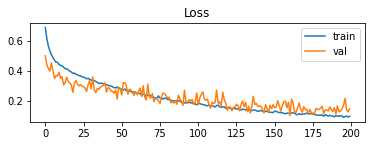

In [116]:
plot_history(history)

In [168]:
r = np.random.choice(range(len(y_data[~test_map])), 5000)
y_out = model(x_data[~test_map][r])
y_pred = y_out >= 0.5
f1 = sklearn.metrics.f1_score(y_data[~test_map][r], y_pred)
f1

0.8437832093517535

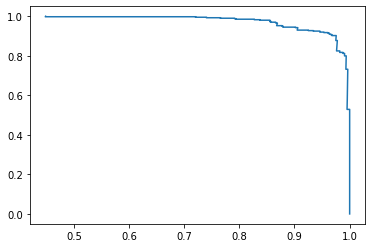

In [176]:
roc = sklearn.metrics.precision_recall_curve(y_data[~test_map][r], y_out)
plt.plot(roc[0], roc[1])

In [154]:
rs = np.reshape(y_out > 0.5, len(y_out))

rs & (y_data[~test_map][r] == 1)

array([False, False,  True, ..., False,  True, False])

In [156]:
np.unique(rs & (y_data[~test_map][r] == 1), return_counts=True)

(array([False,  True]), array([4586,  414]))

In [157]:
np.unique(rs, return_counts=True)

(array([False,  True]), array([4469,  531]))

In [158]:
np.unique(y_data[~test_map][r] == 1, return_counts=True)

(array([False,  True]), array([4585,  415]))